In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
from pandas.tseries.offsets import BDay

from util.file_util import StockTwitsFileReader, StockDataFileReader
# from util.stocktwits_helper import 
from util.stockdata_helper import (
    get_nday_returns_for_ticker, get_nday_mkt_adjusted_returns_for_ticker)

from util.ts_util import (
    shift_date_index, calc_corr, 
    resample_weekly, rolling_weekly)
from util.plot_util import plot_time_series_bar, overlay_on_secondary_axis
import numpy as np
# from config import STOCKTWITS_TICKER_LIST
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
start_date = '2018-01-01'
end_date = '2019-08-10'

In [5]:
twit_file_reader = StockTwitsFileReader() 
stock_file_reader = StockDataFileReader()

In [6]:
ticker_list = [
    # 2019 IPO Stocks
    'BYND',  # Beyond Meat
    'UBER',  # Uber
    'LYFT',  # Lyft
    'WORK',  # Slack
    'ZM',  # Zoom
    'PINS',  # Pinterest
    'CHWY',  # Chewy
    'CRWD',  # Crowdstrike
]

## Data Basic Stat Check by Ticker

- We should ignore tickers with only few Twits

In [7]:
stats = []

for ticker in ticker_list:
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    n_days = twit_df.shape[0]
    total_twits = twit_df.sum().sum()
    avg_twits = total_twits / n_days
    
    stats.append({
        'ticker': ticker, 
        'total_twits': total_twits,
        'avg_twits': avg_twits,
        'n_days': n_days,
    })

In [8]:
stat_df = pd.DataFrame(stats).sort_values('avg_twits', ascending=False)

In [9]:
stat_df[stat_df['avg_twits'] > 1.5]

,avg_twits,n_days,ticker,total_twits
0,768.458333,72,BYND,55329.0
2,178.360825,97,LYFT,17301.0
1,136.268657,67,UBER,9130.0
6,82.857143,42,CHWY,3480.0
5,51.939759,83,PINS,4311.0
7,44.047619,42,CRWD,1850.0
3,37.783784,37,WORK,1398.0
4,26.158537,82,ZM,2145.0


## Weekly Sentiment by Ticker

In [10]:
sample_ticker = 'BYND'

In [11]:
sample_twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(sample_ticker)
sample_wkly_twit_df = resample_weekly(sample_twit_df)

sample_stock_df = stock_file_reader.read_stockdata_in_range(sample_ticker, start_date, end_date)

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


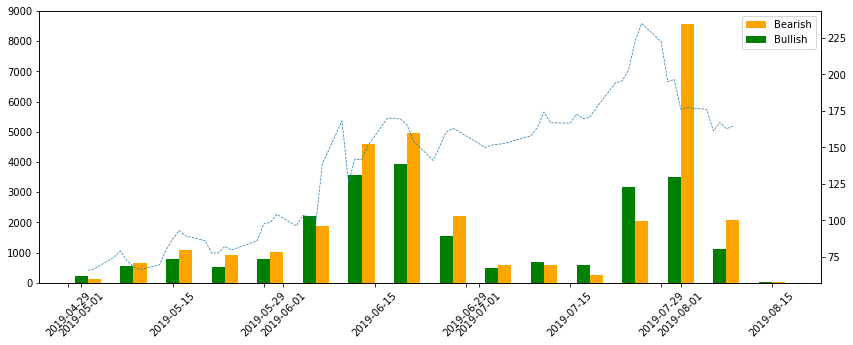

In [12]:
ax = plot_time_series_bar(sample_wkly_twit_df, 
                          figsize=(14, 5),)

overlay_on_secondary_axis(sample_stock_df, 'adjusted close', ax)

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warning

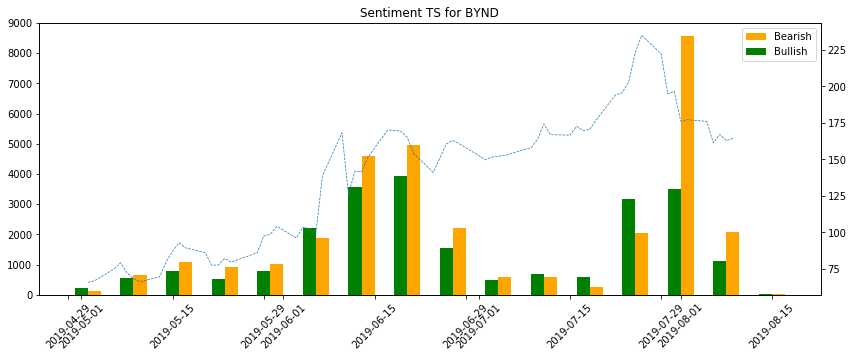

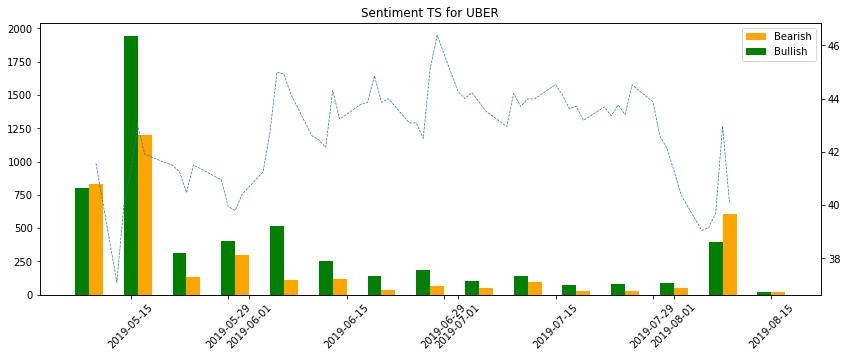

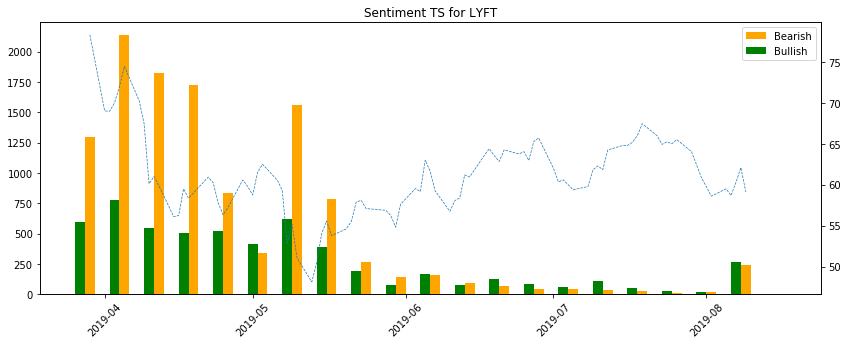

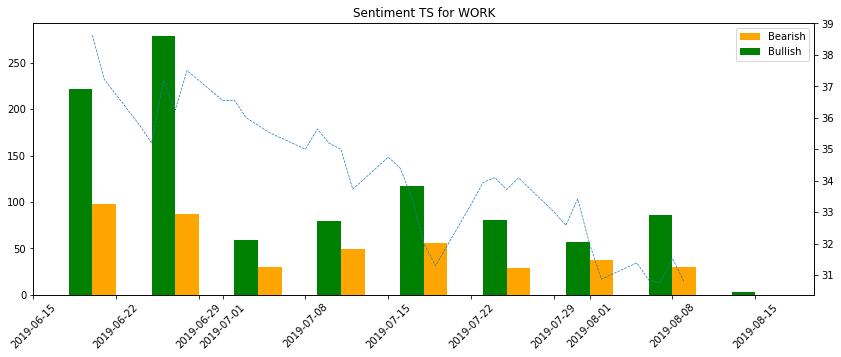

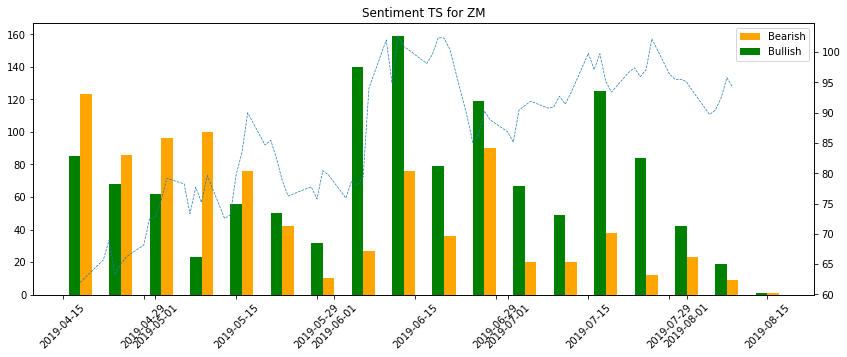

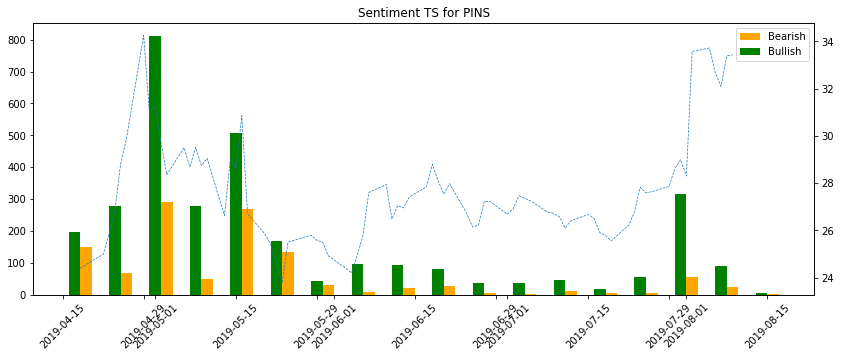

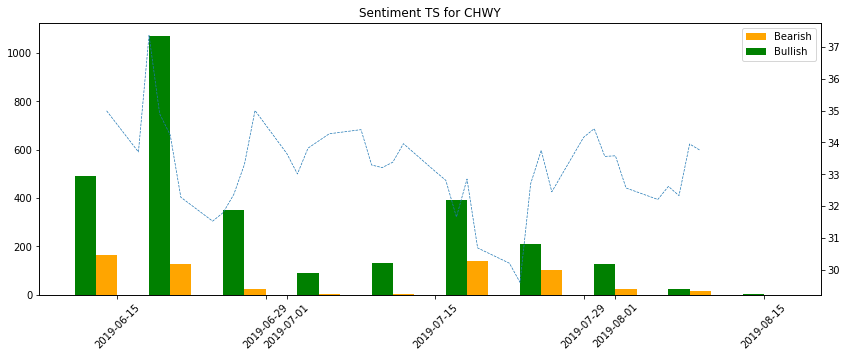

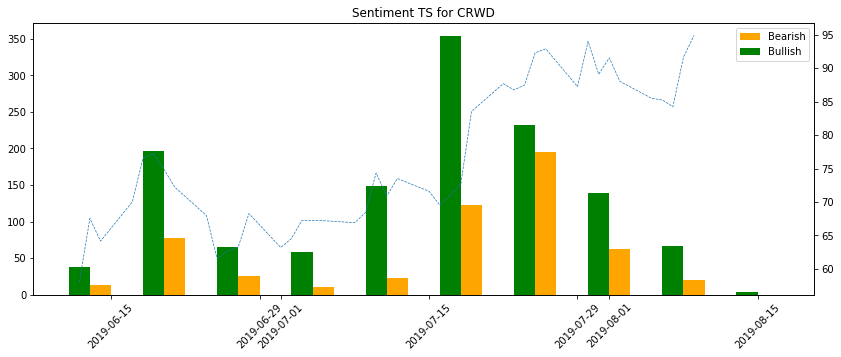

In [13]:
for ticker in ticker_list:
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    stock_df = stock_file_reader.read_stockdata_in_range(ticker, start_date, end_date)
    
    wkly_twit_df_resample = resample_weekly(twit_df)
#     wkly_twit_df_rolling = rolling_weekly(twit_df)
    ax = plot_time_series_bar(wkly_twit_df_resample, 
                         figsize=(14, 5),
                         title='Sentiment TS for {}'.format(ticker))
    overlay_on_secondary_axis(stock_df, 'adjusted close', ax)

## Daily correlations by ticker / lag

In [14]:
import seaborn as sns

#### Bullish / Bearish

In [22]:
sentiment_type = 'Bullish'

In [23]:
n_lags = [-5, -3, -1, 0, 1, 3, 5]

In [24]:
corr_summary = []

for ticker in ticker_list:
    # lag is wrt stock twits (hence, lag = 1 means Twits lead by 1 day)
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    mkt_adjust_return = get_nday_mkt_adjusted_returns_for_ticker(ticker, start_date, end_date,
                                                                 n_days=1)
    
    for lag in n_lags:
        if lag == 0:
            shifted_twit_df = twit_df
        else:
            shifted_twit_df = shift_date_index(twit_df, lag)

        corr = calc_corr(shifted_twit_df, 
                         mkt_adjust_return,
                         sentiment_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': ticker,
            'sentiment_type': sentiment_type,
            'lag': lag,
            'corr': corr,
        })

In [47]:
sizes = []

for ticker in ticker_list:
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    sizes.append(twit_df.shape[0])

In [50]:
np.mean(sizes)

65.25

In [25]:
corr_summary_df = pd.DataFrame(corr_summary)

In [26]:
corr_summary_pivot = corr_summary_df.pivot_table(index='ticker', values='corr', columns='lag').round(2)

In [27]:
corr_summary_pivot

lag,-5,-3,-1,0,1,3,5
ticker,,,,,,,
BYND,-0.05,0.13,0.26,0.23,-0.15,-0.10,-0.04
CHWY,-0.03,-0.04,0.18,-0.29,-0.05,-0.20,-0.24
CRWD,0.06,0.05,0.22,0.48,0.10,-0.11,-0.14
LYFT,-0.18,-0.16,-0.16,-0.22,-0.30,0.01,0.04
PINS,0.08,0.20,0.23,0.17,-0.13,-0.20,0.08
UBER,-0.04,-0.06,0.14,0.07,-0.02,0.15,-0.12
WORK,-0.25,-0.10,-0.14,-0.09,-0.13,0.28,0.17
ZM,-0.11,0.06,0.17,0.48,-0.05,0.10,-0.02


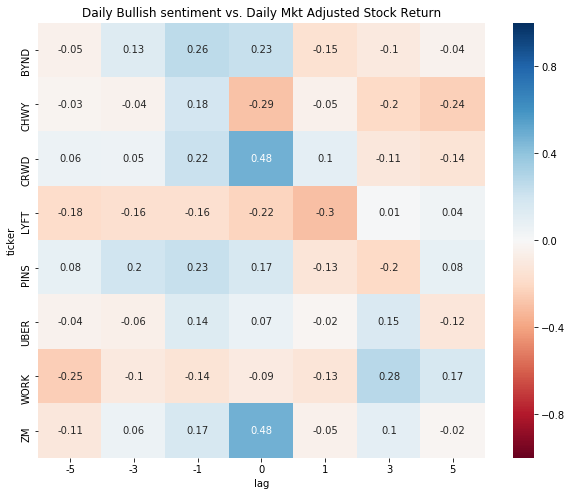

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr_summary_pivot, 
                      annot=True, 
                      cmap='RdBu', 
                      ax=ax, 
                      center=0,
                      vmin=-1, vmax=1)
_ = heatmap.set_title('Daily {} sentiment vs. Daily Mkt Adjusted Stock Return'.format(sentiment_type))

In [37]:
sent_calc_type = 'Bullish_Bearish_log_odds'

In [38]:
temp_dfs = []

In [39]:
corr_summary = []

for ticker in ticker_list:
    # lag is wrt stock twits (hence, lag = 1 means Twits lead by 1 day)
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    mkt_adjust_return = get_nday_mkt_adjusted_returns_for_ticker(ticker, start_date, end_date,
                                                                 n_days=1)
    
    for lag in n_lags:
        if lag == 0:
            shifted_twit_df = twit_df
        else:
            shifted_twit_df = shift_date_index(twit_df, lag)
        
        c_bullish = shifted_twit_df['Bullish']
        c_bearish = shifted_twit_df['Bearish']
        
        shifted_twit_df['Bullish_Minus_Bearish'] = c_bullish - c_bearish
        shifted_twit_df['Bullish_Bearish_log_odds'] = np.log(c_bullish / c_bearish)
        shifted_twit_df['Bullish_Sum_Bearish'] = c_bullish + c_bearish
        shifted_twit_df['Agreement'] =\
            1 - np.sqrt(1 - np.power((c_bullish - c_bearish) / (c_bullish + c_bearish), 2))
        
        temp_dfs.append(shifted_twit_df)
        
        corr = calc_corr(shifted_twit_df, 
                         mkt_adjust_return,
                         sent_calc_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': ticker,
            'sentiment_type': sent_calc_type,
            'lag': lag,
            'corr': corr,
        })
        

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


In [40]:
temp_df = pd.concat(temp_dfs)

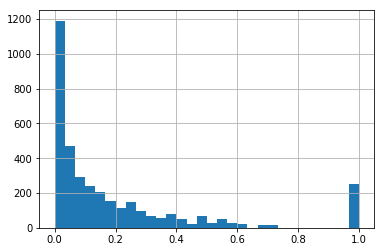

In [41]:
temp_df['Agreement'].hist(bins=30)

In [42]:
corr_summary_df = pd.DataFrame(corr_summary)
corr_summary_pivot = corr_summary_df.pivot_table(index='ticker', values='corr', columns='lag').round(2)

In [43]:
corr_summary_pivot

lag,-5,-3,-1,0,1,3,5
ticker,,,,,,,
BYND,-0.05,-0.00,0.21,0.51,0.01,-0.12,0.09
CHWY,-0.22,-0.01,0.27,0.06,-0.19,-0.19,-0.13
CRWD,-0.19,0.05,-0.06,0.19,0.09,-0.16,0.28
LYFT,0.05,0.02,0.26,0.35,0.05,-0.17,-0.05
PINS,-0.07,-0.07,0.05,0.30,0.07,0.04,-0.01
UBER,0.01,-0.10,0.19,0.38,-0.15,-0.37,-0.12
WORK,0.01,0.03,0.18,0.61,-0.33,0.03,-0.03
ZM,-0.23,-0.17,-0.04,0.23,-0.11,-0.04,0.05


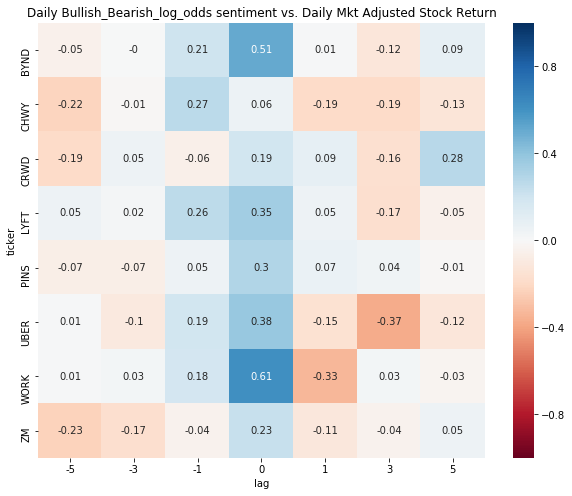

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr_summary_pivot, 
                      annot=True, 
                      cmap='RdBu', 
                      ax=ax, 
                      center=0,
                      vmin=-1, vmax=1)
_ = heatmap.set_title('Daily {} sentiment vs. Daily Mkt Adjusted Stock Return'.format(sent_calc_type))

## Correlation of Weekly Sentiment vs. Daily Return

In [47]:
sentiment_type = 'Bullish_Minus_Bearish'

In [48]:
corr_summary = []

for ticker in ticker_list:
    # lag is wrt stock twits (hence, lag = 1 means Twits lead by 1 day)
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    
    twit_rolling_weekly_df = rolling_weekly(twit_df)
    
    mkt_adjust_return = get_nday_mkt_adjusted_returns_for_ticker(ticker, start_date, end_date,
                                                                 n_days=1)
    
    for lag in n_lags:
        if lag == 0:
            shifted_twit_df = twit_rolling_weekly_df
        else:
            shifted_twit_df = shift_date_index(twit_rolling_weekly_df, lag)
            
        shifted_twit_df['Bullish_Minus_Bearish'] = shifted_twit_df['Bullish'] - shifted_twit_df['Bearish']
        shifted_twit_df['Bullish_Bearish_log_odds'] = np.log(shifted_twit_df['Bullish'] / shifted_twit_df['Bearish'])

        corr = calc_corr(shifted_twit_df, 
                         mkt_adjust_return,
                         sentiment_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': ticker,
            'sentiment_type': sentiment_type,
            'lag': lag,
            'corr': corr,
        })

In [49]:
corr_summary_df = pd.DataFrame(corr_summary)
corr_summary_pivot = corr_summary_df.pivot_table(index='ticker', values='corr', columns='lag').round(2)

In [50]:
corr_summary_pivot

lag,-5,-3,-1,0,1,3,5
ticker,,,,,,,
BYND,-0.03,0.24,0.28,0.20,0.08,0.11,0.14
CHWY,-0.04,-0.08,-0.11,-0.19,-0.18,-0.01,0.13
CRWD,0.04,0.34,0.14,0.20,-0.14,0.04,0.10
LYFT,0.28,0.40,0.20,0.09,-0.06,0.04,0.16
PINS,0.21,0.27,0.05,-0.01,-0.16,-0.08,-0.09
UBER,0.07,0.24,0.14,0.11,-0.13,-0.07,0.11
WORK,-0.28,-0.13,0.10,0.07,0.05,-0.04,-0.07
ZM,-0.10,0.12,0.10,0.04,-0.12,-0.11,-0.12


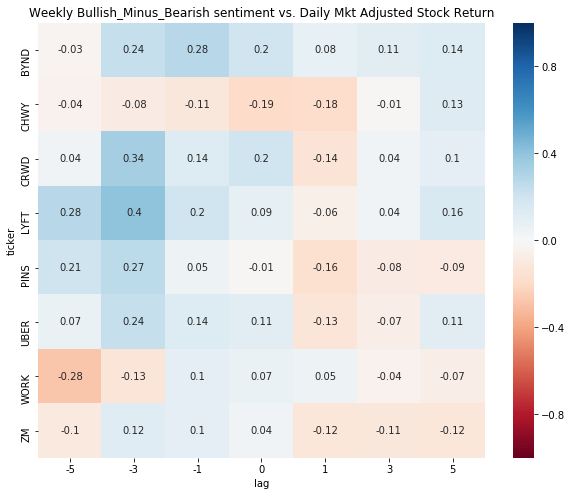

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr_summary_pivot, 
                      annot=True, 
                      cmap='RdBu', 
                      ax=ax, 
                      center=0,
                      vmin=-1, vmax=1)
_ = heatmap.set_title('Weekly {} sentiment vs. Daily Mkt Adjusted Stock Return'.format(sentiment_type))

### Correlation of Daily Sentiment vs. Different Range Returns

In [52]:
sentiment_type = 'Bullish_Minus_Bearish'

In [54]:
corr_summary = []

for ticker in ticker_list:
    # lag is wrt stock twits (hence, lag = 1 means Twits lead by 1 day)
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    
    for n_day in [1, 3, 5]:
    
        mkt_adjust_return = get_nday_mkt_adjusted_returns_for_ticker(ticker, start_date, end_date,
                                                                     n_days=n_day)
        shifted_twit_df = shift_date_index(twit_df, n_day)
        
        shifted_twit_df['Bullish_Minus_Bearish'] = shifted_twit_df['Bullish'] - shifted_twit_df['Bearish']
        shifted_twit_df['Bullish_Bearish_log_odds'] = np.log(shifted_twit_df['Bullish'] / shifted_twit_df['Bearish'])

        corr = calc_corr(shifted_twit_df, 
                         mkt_adjust_return,
                         sentiment_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': ticker,
            'sentiment_type': sentiment_type,
            'n_day_return': n_day,
            'corr': corr,
        })

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


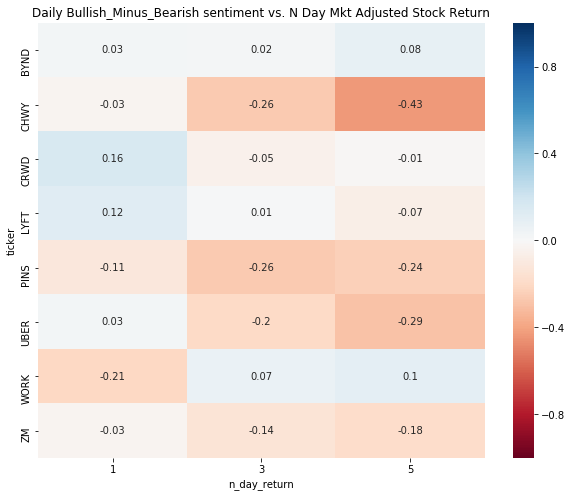

In [55]:
corr_summary_df = pd.DataFrame(corr_summary)
corr_summary_pivot = corr_summary_df.pivot_table(index='ticker', values='corr', columns='n_day_return').round(2)

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr_summary_pivot, 
                      annot=True, 
                      cmap='RdBu', 
                      ax=ax, 
                      center=0,
                      vmin=-1, vmax=1)
_ = heatmap.set_title('Daily {} sentiment vs. N Day Mkt Adjusted Stock Return'.format(sentiment_type))

In [56]:
corr_summary_pivot

n_day_return,1,3,5
ticker,,,
BYND,0.03,0.02,0.08
CHWY,-0.03,-0.26,-0.43
CRWD,0.16,-0.05,-0.01
LYFT,0.12,0.01,-0.07
PINS,-0.11,-0.26,-0.24
UBER,0.03,-0.20,-0.29
WORK,-0.21,0.07,0.10
ZM,-0.03,-0.14,-0.18
